# Human Performance Monitoring Module (HPMM)
Authors: Jiawei Chen & Ruoxin Xiong, Carnegie Mellon University

Email: ruoxinx@andrew.cmu.edu

# Overview of HPMM Module
This module uses data collected from ASU's Air Traffic Controller Simulation Experiments where three 25 minute approach scenarios were simulated - a baseline workload, a high workload under nominal conditions, and a high workload under off-nominal conditions. Information on these data can be found on the ASU ULI's website [here](https://uli.asu.edu/wp-content/uploads/2020/08/Presentation-AIAA-talk-2019-Task-3-Human-Systems-Integration.pdf). 

The sample data is collected from controller-in-the-loop simulation experiments during the air traffic control tasks. The performance measure of the ATC experiments in each scenario were Loss of Separation (LoS) where aircraft fail to maintain minimum separation distances in controlled airspace. This module uses LoS as an indicator of the air traffic controller's operational performance. 


## Installing the required Python packages

The required Python packages for this module are:
- ***[```catboost```]***(https://catboost.ai/docs/installation/python-installation-method-pip-install.html#python-installation-method-pip-install)
- ***[```pandas```]***
- ***[```numpy```]***
- ***[```sklearn```]***

In the Ubuntu or Anaconda terminal, execute ```conda install catboost pandas numpy sklearn```. 

## Step 1: Processing and Visualizing ATC Data
### Step 1a: Import ```human_data.csv```

In [1]:
import pandas as pd

df = pd.read_csv('./human_data.csv')

df.head()

,Ss,condtn,at_sec,traffic_density,los_freq,los_dur_over5min,cum_los_dur,query,ready_latency,ready_latency_adj,...,wl_rating,interbeat_interval,condtn_num,rx,ry,rz,eyeblink,negative,neutral,positive
0,1,baseline,0,1,0,0,0,WL,2.07,2.07,...,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline,5,1,0,0,0,WL,2.07,2.07,...,1.0,NaN,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,baseline,10,1,0,0,0,WL,2.07,2.07,...,1.0,585.0,1,0.262433,0.230592,-0.039242,0.254250,0.800000,0.100000,0.100000
3,1,baseline,15,1,0,0,0,WL,2.07,2.07,...,1.0,871.0,1,0.248067,0.146753,-0.020133,0.531800,0.285714,0.428571,0.285714
4,1,baseline,20,2,0,0,0,WL,2.07,2.07,...,1.0,894.0,1,0.247920,0.179927,-0.066440,0.087133,0.906250,0.093750,0.000000


### Step 1b. Downselect columns

Drop specified columns of redundant variables for LoS prediction. 

In [2]:
cols_to_drop = ['Ss', 'at_sec', 'condtn', 'ready_latency', 'query_latency', 'response_index', 
                 'los_dur_over5min','query_timed_out', 'ready_timed_out', 'ready_latency_adj',
                 'cum_los_dur','stimuli', 'response_text', 'condtn_num', 'query']

df.drop(columns=cols_to_drop, inplace=True)

df.head()

,traffic_density,los_freq,sa_correct,wl_rating,interbeat_interval,rx,ry,rz,eyeblink,negative,neutral,positive
0,1,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,NaN,1.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0,NaN,1.0,585.0,0.262433,0.230592,-0.039242,0.254250,0.800000,0.100000,0.100000
3,1,0,NaN,1.0,871.0,0.248067,0.146753,-0.020133,0.531800,0.285714,0.428571,0.285714
4,2,0,NaN,1.0,894.0,0.247920,0.179927,-0.066440,0.087133,0.906250,0.093750,0.000000


### Step 1c: Transform LoS into binary class and fill NaN values

In [3]:
# If LoS > 1, impute to 1
df.loc[df.los_freq>1,'los_freq']=1

#If value in column is NaN, replace with mean of column
df.fillna(df.mean(), inplace=True)

df.head()

,traffic_density,los_freq,sa_correct,wl_rating,interbeat_interval,rx,ry,rz,eyeblink,negative,neutral,positive
0,1,0,0.920691,1.0,818.84042,0.117173,-0.022388,-0.052366,0.225100,0.414948,0.205535,0.259012
1,1,0,0.920691,1.0,818.84042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0,0.920691,1.0,585.00000,0.262433,0.230592,-0.039242,0.254250,0.800000,0.100000,0.100000
3,1,0,0.920691,1.0,871.00000,0.248067,0.146753,-0.020133,0.531800,0.285714,0.428571,0.285714
4,2,0,0.920691,1.0,894.00000,0.247920,0.179927,-0.066440,0.087133,0.906250,0.093750,0.000000


### Step 1d: Define predictor and criterion 
Define predictor(X) and criterion(Y)

In [4]:
X = df.drop(columns=['los_freq'])
Y = df['los_freq']

## Step 2:  Training and testing LoS prediction models
In this step, we aim to predict the occurrence of LoS with the various classification models:
1. ```catboost``` Python package. ```catboost``` employs a machine learning based classifier. 
2. Support vector machines (SVM)
3. Decision Tree
4. k-Nearest Neighbors (KNN)
5. Naive Bayes Classifier

### Model Option 1: Load saved ```catboost``` model with PARA-ATM

In [14]:
from paraatm.safety.los import LosModel

losmodel = LosModel('hpmm_catboost_model',model_type='catboost')

### Step 2d: Look at trained model parameters


In [15]:
losmodel.model.get_params()

{'eval_metric': 'Accuracy',
 'depth': 6,
 'loss_function': 'Logloss',
 'learning_rate': 0.1,
 'l2_leaf_reg': 5,
 'verbose': 0}

## Step 3: ```catboost``` Model Evaluation

### Step3a: Prediction with test holdout data
First we will predict the LoS output for X_test and compare with y_test. 

We will evaluate the model based on 3 criteria:
- Precision
- Recall
- F1-score

In [16]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

X_train.head()

y_pred = losmodel(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       588
           1       0.86      0.79      0.82       315

    accuracy                           0.88       903
   macro avg       0.87      0.86      0.86       903
weighted avg       0.88      0.88      0.88       903



### Step 3b: Visualize confusion matrix for test holdout data
A confusion matrix gives visual indication of accuracy at predicting the two labels
- label(0): no LOS
- label(1): LOS

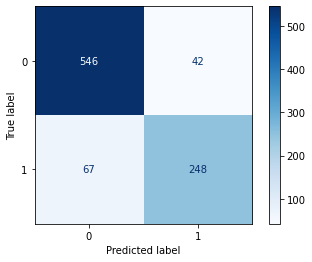

In [22]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(losmodel.model, X_test, y_test, cmap = 'Blues') 

## Step 5: Assess Other Modeling Options
### Model 2: Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma=2, C=1)
svm.fit(X_train, y_train)

pred = svm.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(svm, X_test, y_test, cmap = 'Blues') 

### Model 3: Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(dt, X_test, y_test, cmap = 'Blues') 

### Model 4: k-Nearest Neighbors (kNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(knn, X_test, y_test, cmap = 'Blues') 

### Model 5: Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nn = GaussianNB()
nn.fit(X_train, y_train)

pred = nn.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(nn, X_test, y_test, cmap = 'Blues') 